<a href="https://colab.research.google.com/github/Morsal-stack/EuropeanFunds/blob/main/Progetto_IA_Predizione_Irregolarit%C3%A0_Flussi_Comunitari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROGETTO IA: PREDIZIONE DELLE IRREGOLARITA'**


La prima fase vede l'importazione delle librerie utili per sviluppare il progetto in oggetto.

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import warnings
warnings.filterwarnings("ignore") 

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score



Si importa sul dataframe "df" il dataset 

In [ ]:
df  = pd.read_csv('/content/drive/MyDrive/dataset test indici di rischio.csv')
df.head(10)



,id,Irregolarita,IR Numero di Finanziamenti,IR Alto Importo,IR Procedura,IR Database polizia,IR Societario,IR Segnalazioni esterne,IR Media Importo per Finanziamento
0,842302,1,20,18,25.0,63,20,17.0,12
1,842517,1,19,15,24.0,52,19,20.0,13
2,84300903,1,17,15,23.0,61,17,19.0,13
3,84348301,1,56,98,14.0,91,56,11.0,77
4,84358402,1,15,15,22.0,14,15,20.0,13
5,843786,1,74,10,15.0,75,74,12.0,82
6,844359,1,16,15,22.0,43,16,18.0,11
7,84458202,1,89,11,17.0,88,89,13.0,90
8,844981,1,73,10,15.0,57,73,13.0,87
9,84501001,1,71,97,15.0,71,71,12.0,83


Si elimina la colonna "id" che non è utile per il training.

In [ ]:
df.drop(['id'], axis = 1 , inplace=True)
df.columns

Index(['Irregolarita', 'IR Numero di Finanziamenti', 'IR Alto Importo',
       'IR Procedura', 'IR Database polizia', 'IR Societario',
       'IR Segnalazioni esterne', 'IR Media Importo per Finanziamento '],
      dtype='object')

Verifica delle modifiche effettuate. 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Irregolarita                         569 non-null    int64  
 1   IR Numero di Finanziamenti           569 non-null    int64  
 2   IR Alto Importo                      569 non-null    int64  
 3   IR Procedura                         569 non-null    float64
 4   IR Database polizia                  569 non-null    int64  
 5   IR Societario                        569 non-null    int64  
 6   IR Segnalazioni esterne              569 non-null    float64
 7   IR Media Importo per Finanziamento   569 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 35.7 KB


Si ricontrolla che le modifiche siano state effettuate.

La funzione getModelEvaluationMetrics permetterà di stampare le matrici di confusione, la precisione e la sensitività per ogni modello di training che si svilupperà.

In [ ]:

def getModelEvaluationMetrics(classifier, model_name: str, x_test: pd.core.frame.DataFrame,
                              y_test: pd.core.frame.DataFrame, y_predicted, plot_confusion_matrix=False,
                              figsize=(10, 8)) -> np.ndarray:

    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_predicted)
    print('Matrice di confusione:\n\n {0}'.format(conf_mat))

    if plot_confusion_matrix:
        labels = ['1', '0']
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        cax = ax.matshow(conf_mat, cmap=plt.cm.Reds)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.style.use('fivethirtyeight')
        sns.set_style("white")
        plt.xlabel('Predetti')
        plt.ylabel('Attesi')
        plt.title(f'Matrice di confusione per {model_name}', fontweight='bold')
        plt.show()

    # Calcolo della precisione (tp/tp+fp) dove tp sta per true precision ed fp per false positive
    precision = str(np.round((conf_mat[1][1] / (conf_mat[1][1] +
                              conf_mat[0][1])) * 100, 2))
    print('La precione è del: {0} %'.format(precision))

    # Calcolo della sensitività (tp/tp+fn) dove tp sta per true precision ed fn per false negative
    recall = str(np.round((conf_mat[1][1] / (conf_mat[1][1] +
                           conf_mat[1][0])) * 100, 2))
    print('La sensitività è del: {0} %'.format(recall))

    return conf_mat

Si mostra la correlazione del dataframe evidenziando in blu i valori calcolati per ogni due variabili che si avvicinano all'unità, in verde i valori intermedi mentre in giallo le correlazioni prossime allo zero.

Text(0.5, 1.0, 'Correlation Map')

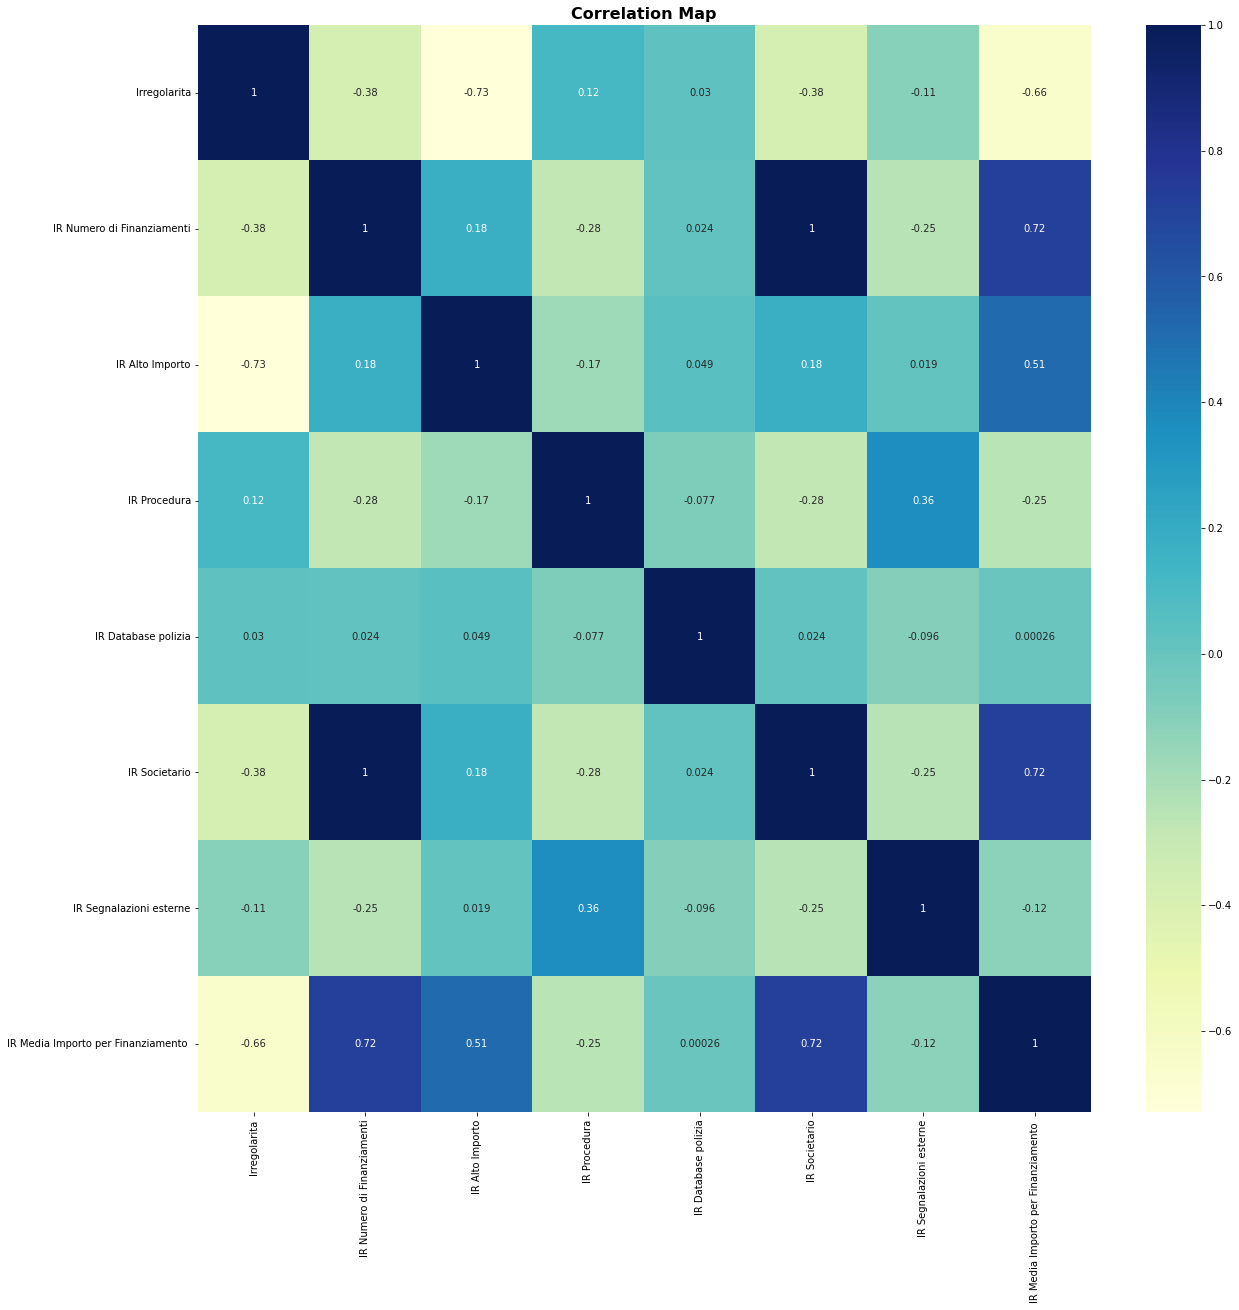

In [ ]:
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), cmap='YlGnBu', annot = True)
plt.title("Correlation Map", fontweight = "bold", fontsize=16)

Nella seguente cella si mostra la correlazione che sussiste tra ogni caratteristica della massa estratta con i target

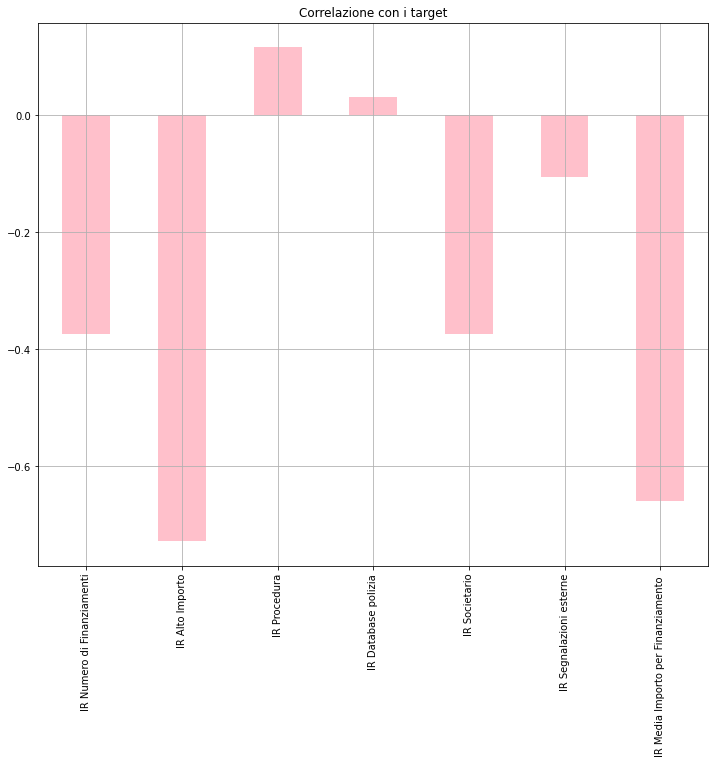

In [ ]:
df.drop('Irregolarita', axis=1).corrwith(df.Irregolarita).plot(kind='bar', grid=True, figsize=(12, 10), title="Correlazione con i target",color="pink");

Grafico che mostra la correlazione tenendo conto di una soglia (in questo caso 0,60) 

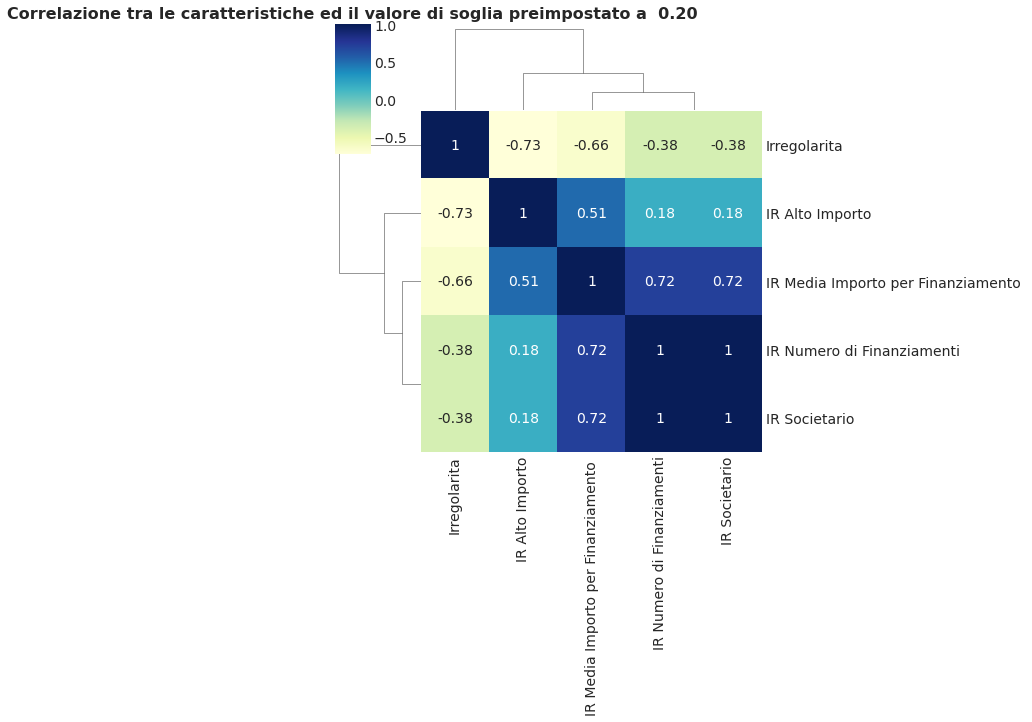

In [ ]:


corr_matrix = df.corr()
threshold = 0.20 
filtre = np.abs(corr_matrix["Irregolarita"]) > threshold
corr_features = corr_matrix.columns[filtre].tolist()
sns.clustermap(df[corr_features].corr(), annot = True, cmap="YlGnBu")
plt.title("Correlazione tra le caratteristiche ed il valore di soglia preimpostato a  0.20", fontweight = "bold", fontsize=16)
plt.show()



In [ ]:
x = df.drop(columns=["Irregolarita"])

In [ ]:
y = df["Irregolarita"]



---



Suddivido i dataframe x e y, assegnando l'80% al dataset di addestramento mentre il 20% a quello deputato al test. 

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

x_train.info

<bound method DataFrame.info of      IR Numero di Finanziamenti  ...  IR Media Importo per Finanziamento 
256                          19  ...                                   13
280                          17  ...                                   12
259                          10  ...                                   10
217                          40  ...                                   65
378                          65  ...                                   88
..                          ...  ...                                  ...
404                          53  ...                                   78
165                          78  ...                                   95
278                          73  ...                                   86
49                           69  ...                                   86
231                          45  ...                                   71

[455 rows x 7 columns]>

Si compila il modello, utilizzando come ottimizzatore il metodo Adam (Adaptive momentum estimation) mentre essendo che il problema di classificazione è binario, il parametro loss deve essere asserito a "binary_crossentropy".

Si vuole paragonare quanto rilevato con il modello della Regressione Logistica e del Classificatore "Random Forest", mostrando per ognuno di essi la matrice di confusione, l'accuratezza, la precisione, la sensitività, nonchè il vettore delle predizioni utilizzando il set x_train.

In [ ]:
predict = model.predict(x_test)
print(predict)

In [ ]:
    getModelEvaluationMetrics(classifier=LogisticRegression, model_name=model,x_test=x_test, y_test=y_test, y_predicted=predict,
                               plot_confusion_matrix=True, figsize=(8,6))

ValueError: ignored

In [ ]:
key = ['LogisticRegression','RandomForestClassifier']
value = [LogisticRegression(), RandomForestClassifier(n_estimators=60, random_state=0)]
models = dict(zip(key,value))
models

{'LogisticRegression': LogisticRegression(),
 'RandomForestClassifier': RandomForestClassifier(n_estimators=60, random_state=0)}

LogisticRegression : Accuratezza del: 0.9210526315789473 . Irregolarità predette: [0 0 1 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0 0 0
 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1
 1 0 0]
Matrice di confusione:

 [[68  6]
 [ 3 37]]


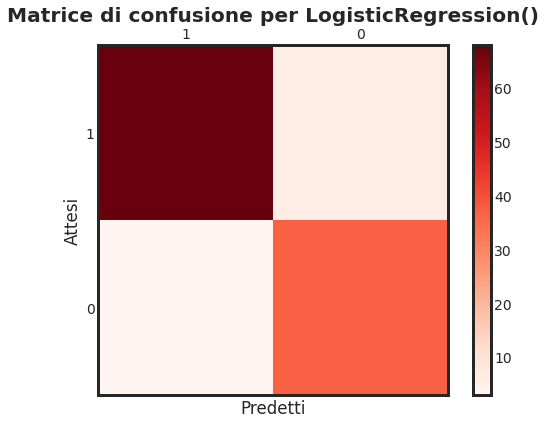

La precione è del: 86.05 %
La sensitività è del: 92.5 %
RandomForestClassifier : Accuratezza del: 0.9385964912280702 . Irregolarità predette: [0 0 1 1 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 0 0 0 0
 1 1 0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1
 0 0 0]
Matrice di confusione:

 [[71  3]
 [ 4 36]]


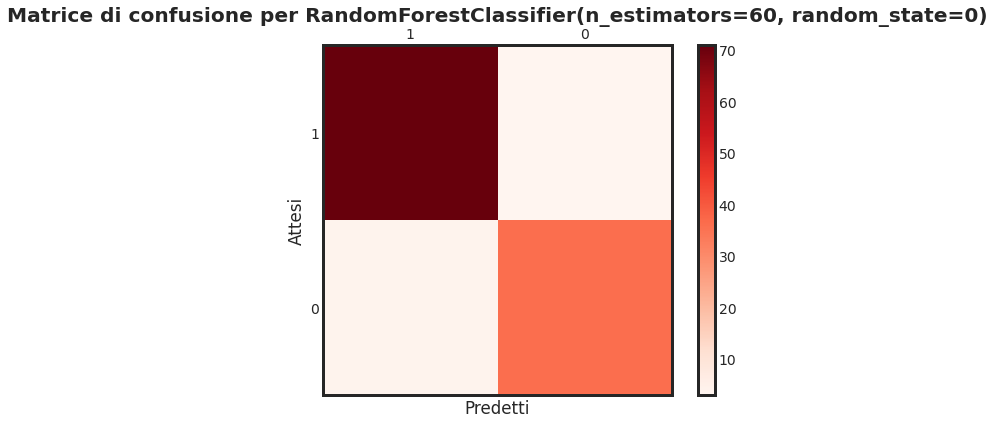

La precione è del: 92.31 %
La sensitività è del: 90.0 %


In [ ]:
predicted =[]
for name,algo in models.items():
    model=algo
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    acc = accuracy_score(y_test, predict)
    predicted.append(acc)
    print(name,': Accuratezza del:',acc, '. Irregolarità predette:', predict)
    getModelEvaluationMetrics(classifier=LogisticRegression, model_name=model,x_test=x_test, y_test=y_test,
                              y_predicted=predict, plot_confusion_matrix=True, figsize=(8,6))

Text(0.5, 1.0, 'Accuratezza tra i due modelli della libreria sklearn ')

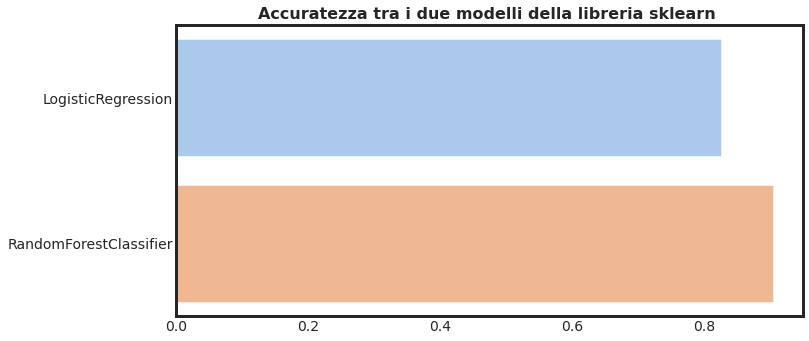

In [ ]:
plt.figure(figsize = (10,5))
sns.barplot(x = predicted, y = key, palette='pastel')
plt.title("Accuratezza tra i due modelli della libreria sklearn ", fontsize=16, fontweight="bold")

